In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.table import Table
from exoplanet.gp import terms, GP
import exoplanet as xo
from kde_contour import kdeplot_2d_clevels
import pandas as pd
import pymc3 as pm
import scipy.stats as ss
import seaborn as sns
import theano
import theano.tensor as tt
from tqdm import tqdm
import warnings

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

These formulas come from [Kallinger, et al. (2014)](http://dx.doi.org/10.1051/0004-6361/201424313) and [Cohelo, et al. (2015)](http://dx.doi.org/10.1093/mnras/stv1175); particularly the latter is only calibrated against sub-giants, so who knows....

In [7]:
teff_solar = 5777.0
logg_solar = 4.4374

numax_solar = 3090.0*1e-6*3600.0*24.0
nugran_solar = 30*1e-6*3600.0*24.0

def est_numax(logg, teff):
    numax_est = numax_solar*10**(logg-logg_solar)*sqrt(teff/teff_solar)
    return numax_est

def est_nugran(numax):
    nugran_est = nugran_solar * (numax/numax_solar)**0.89
    return nugran_est

In [9]:
visit = Table.read('../apogee/allVisit-v603.fits').to_pandas()
stars = Table.read('../apogee/allStar-v603.fits', hdu=1)

names = [name for name in stars.colnames if len(stars[name].shape) <= 1]
stars = stars[names].to_pandas()

stars = stars.assign(NUMAX_EST=lambda s: est_numax(s['LOGG'], s['TEFF']), NUGRAN_EST=lambda s: est_nugran(s['NUMAX_EST']))

joint = pd.merge(visit, stars, on='APOGEE_ID')
joint = joint.sort_values(['APOGEE_ID', 'JD'])

In [10]:
rgs = joint[(joint['LOGG'] < 2) & (joint['LOGG'] > -1000)]

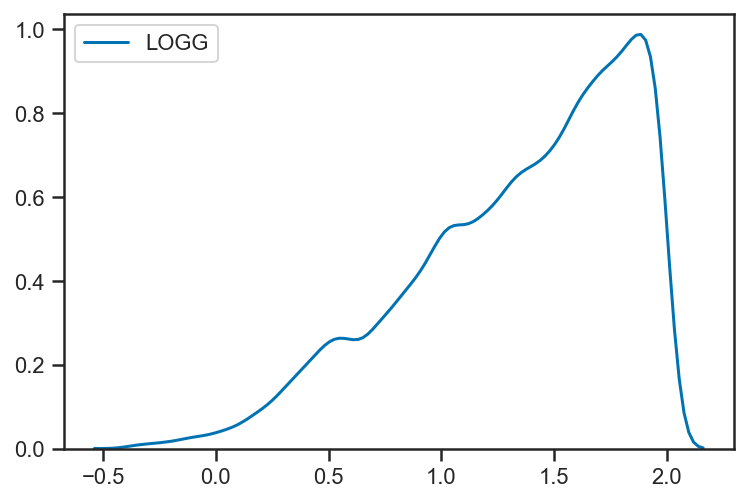

In [11]:
sns.kdeplot(rgs['LOGG'])

In [12]:
by_aid = rgs.groupby('APOGEE_ID')
num_visits = by_aid.apply(lambda r: count_nonzero(diff(sort(r['JD'])) < 1.0/r['NUMAX_EST'].iloc[0]))

In [13]:
num_visits = num_visits.sort_values(ascending=False)

These are the cumulative number of APOGEE RGs with a certain number of visits separated by less than one oscillation period.  There are ~75 or so with more than 10 visits.  Not awesome, but could be interesting.

(array([15188., 23110., 25473., 26250., 26576., 26681., 26739., 26815.,
        26843., 26858., 26866., 26878., 26884., 26896., 26897., 26900.,
        26901., 26901., 26904., 26909., 26909., 26911., 26912., 26912.,
        26913., 26913., 26913., 26913., 26913., 26914.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30.]),
 <a list of 1 Patch objects>)

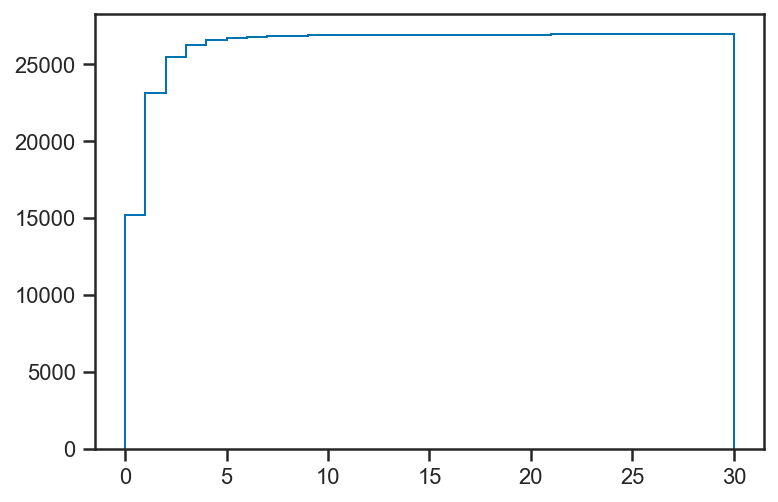

In [14]:
hist(num_visits, bins=linspace(0, 30, 31), cumulative=True, histtype='step')

In [15]:
i = 1
aid = num_visits.index[i]
d = by_aid.get_group(aid)
d = d.sort_values(by='JD')

In [26]:
print('APOGEE_ID {:s} has NUMAX_EST = {:.2g} / d and NUGRAN_EST = {:.2g} / d'.format(str(d['APOGEE_ID'].iloc[0]), d['NUMAX_EST'].iloc[0], d['NUGRAN_EST'].iloc[0]))

APOGEE_ID b'2M18510234-0150075' has NUMAX_EST = 0.12 / d and NUGRAN_EST = 0.0027 / d


b'2M18510234-0150075' has log(g) = 1.16


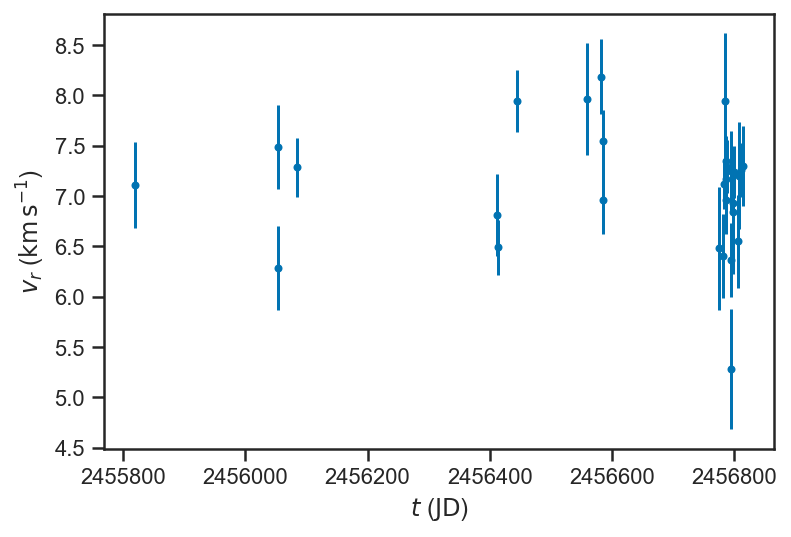

In [16]:
errorbar(d['JD'], d['VHELIO'], d['VRELERR'], fmt='.')

xlabel(r"$t$ ($\mathrm{JD}$)")
ylabel(r"$v_r$ ($\mathrm{km} \, \mathrm{s}^{-1}$)")

print('{:s} has log(g) = {:.2f}'.format(str(d['APOGEE_ID'].iloc[0]), d['LOGG'].iloc[0]))

In [19]:
m = mean(d['VHELIO'])
s = std(d['VHELIO'])

d = d.sort_values(by='JD', ascending=True)
d = d[~(isnan(d['JD'])) & ~(isnan(d['VHELIO'])) & ~(isnan(d['VRELERR']))]

w0_est = 2*pi*d['NUMAX_EST'].iloc[0]
S0_est = s*s / (w0_est*2)

wgran_est = 2*pi*d['NUGRAN_EST'].iloc[0]
Sgran_est = s*s/(wgran_est/sqrt(2))

with pm.Model() as model:
    mu = pm.Normal('mu', mu=m, sigma=10*s, testval=m)
    
    log_Sgran = pm.Normal('log_Sgran', mu=log(Sgran_est), sigma=2.0*log(3), testval=log(Sgran_est))
    log_wgran = pm.Normal('log_wgran', mu=log(wgran_est), sigma=log(3), testval=log(wgran_est))
    Qgran = 1/sqrt(2)
    
    log_S0 = pm.Normal('log_S0', mu=log(S0_est), sigma=2.0*log(3), testval=log(S0_est))
    log_w0 = pm.Normal('log_w0', mu=log(w0_est), sigma=log(3), testval=log(w0_est))
    log_Q = pm.Bound(pm.Normal, lower=0.5)('log_Q', mu=log(2), sigma=log(3), testval=log(2))
    
    var_gran = pm.Deterministic('var_gran', tt.exp(log_Sgran + log_wgran + log(Qgran)))
    var_SHO = pm.Deterministic('var_SHO', tt.exp(log_S0 + log_w0 + log_Q))
    _ = pm.Deterministic('var', var_gran+var_SHO)
    _ = pm.Deterministic('wgran', tt.exp(log_wgran))
    _ = pm.Deterministic('w0', tt.exp(log_w0))
    _ = pm.Deterministic('Q', tt.exp(log_Q))
    
    kernel = terms.SHOTerm(log_S0=log_Sgran, log_w0=log_wgran, Q=Qgran)
    kernel += terms.SHOTerm(log_S0=log_S0, log_w0=log_w0, log_Q=log_Q)
    gp = GP(kernel, d['JD'].to_numpy(), (d['VRELERR']*d['VRELERR']).to_numpy().astype(np.float64), mean=mu, J=4)
    
    gp.marginal('gp', observed=d['VHELIO'].to_numpy().astype(np.float64))

In [20]:
with model:
    trace = pm.sample(tune=1000, draws=1000, cores=4, chains=4, step=xo.get_dense_nuts_step())

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_Q, log_w0, log_S0, log_wgran, log_Sgran, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:43<00:00, 183.90draws/s]


In [21]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,7.168,0.231,6.767,7.595,0.007,0.005,1006.0,961.0,1451.0,1108.0,1.0
log_Sgran,1.740,1.656,-1.196,5.051,0.044,0.034,1397.0,1170.0,1436.0,1222.0,1.0
log_wgran,-4.406,1.009,-6.401,-2.599,0.025,0.018,1628.0,1546.0,1661.0,2023.0,1.0
log_S0,-3.345,1.301,-5.777,-0.920,0.035,0.025,1377.0,1343.0,1378.0,1775.0,1.0
log_w0,-0.526,1.025,-2.398,1.539,0.032,0.023,1034.0,1034.0,1084.0,1347.0,1.0
log_Q,1.276,0.603,0.500,2.391,0.015,0.010,1676.0,1676.0,1167.0,915.0,1.0
var_gran,0.142,0.282,0.000,0.483,0.008,0.005,1392.0,1392.0,1312.0,1613.0,1.0
var_SHO,0.112,0.100,0.000,0.276,0.002,0.001,2856.0,2856.0,1927.0,1218.0,1.0
var,0.254,0.299,0.007,0.641,0.008,0.006,1430.0,1430.0,1572.0,1755.0,1.0
wgran,0.020,0.023,0.000,0.056,0.000,0.000,2277.0,2277.0,1661.0,2023.0,1.0


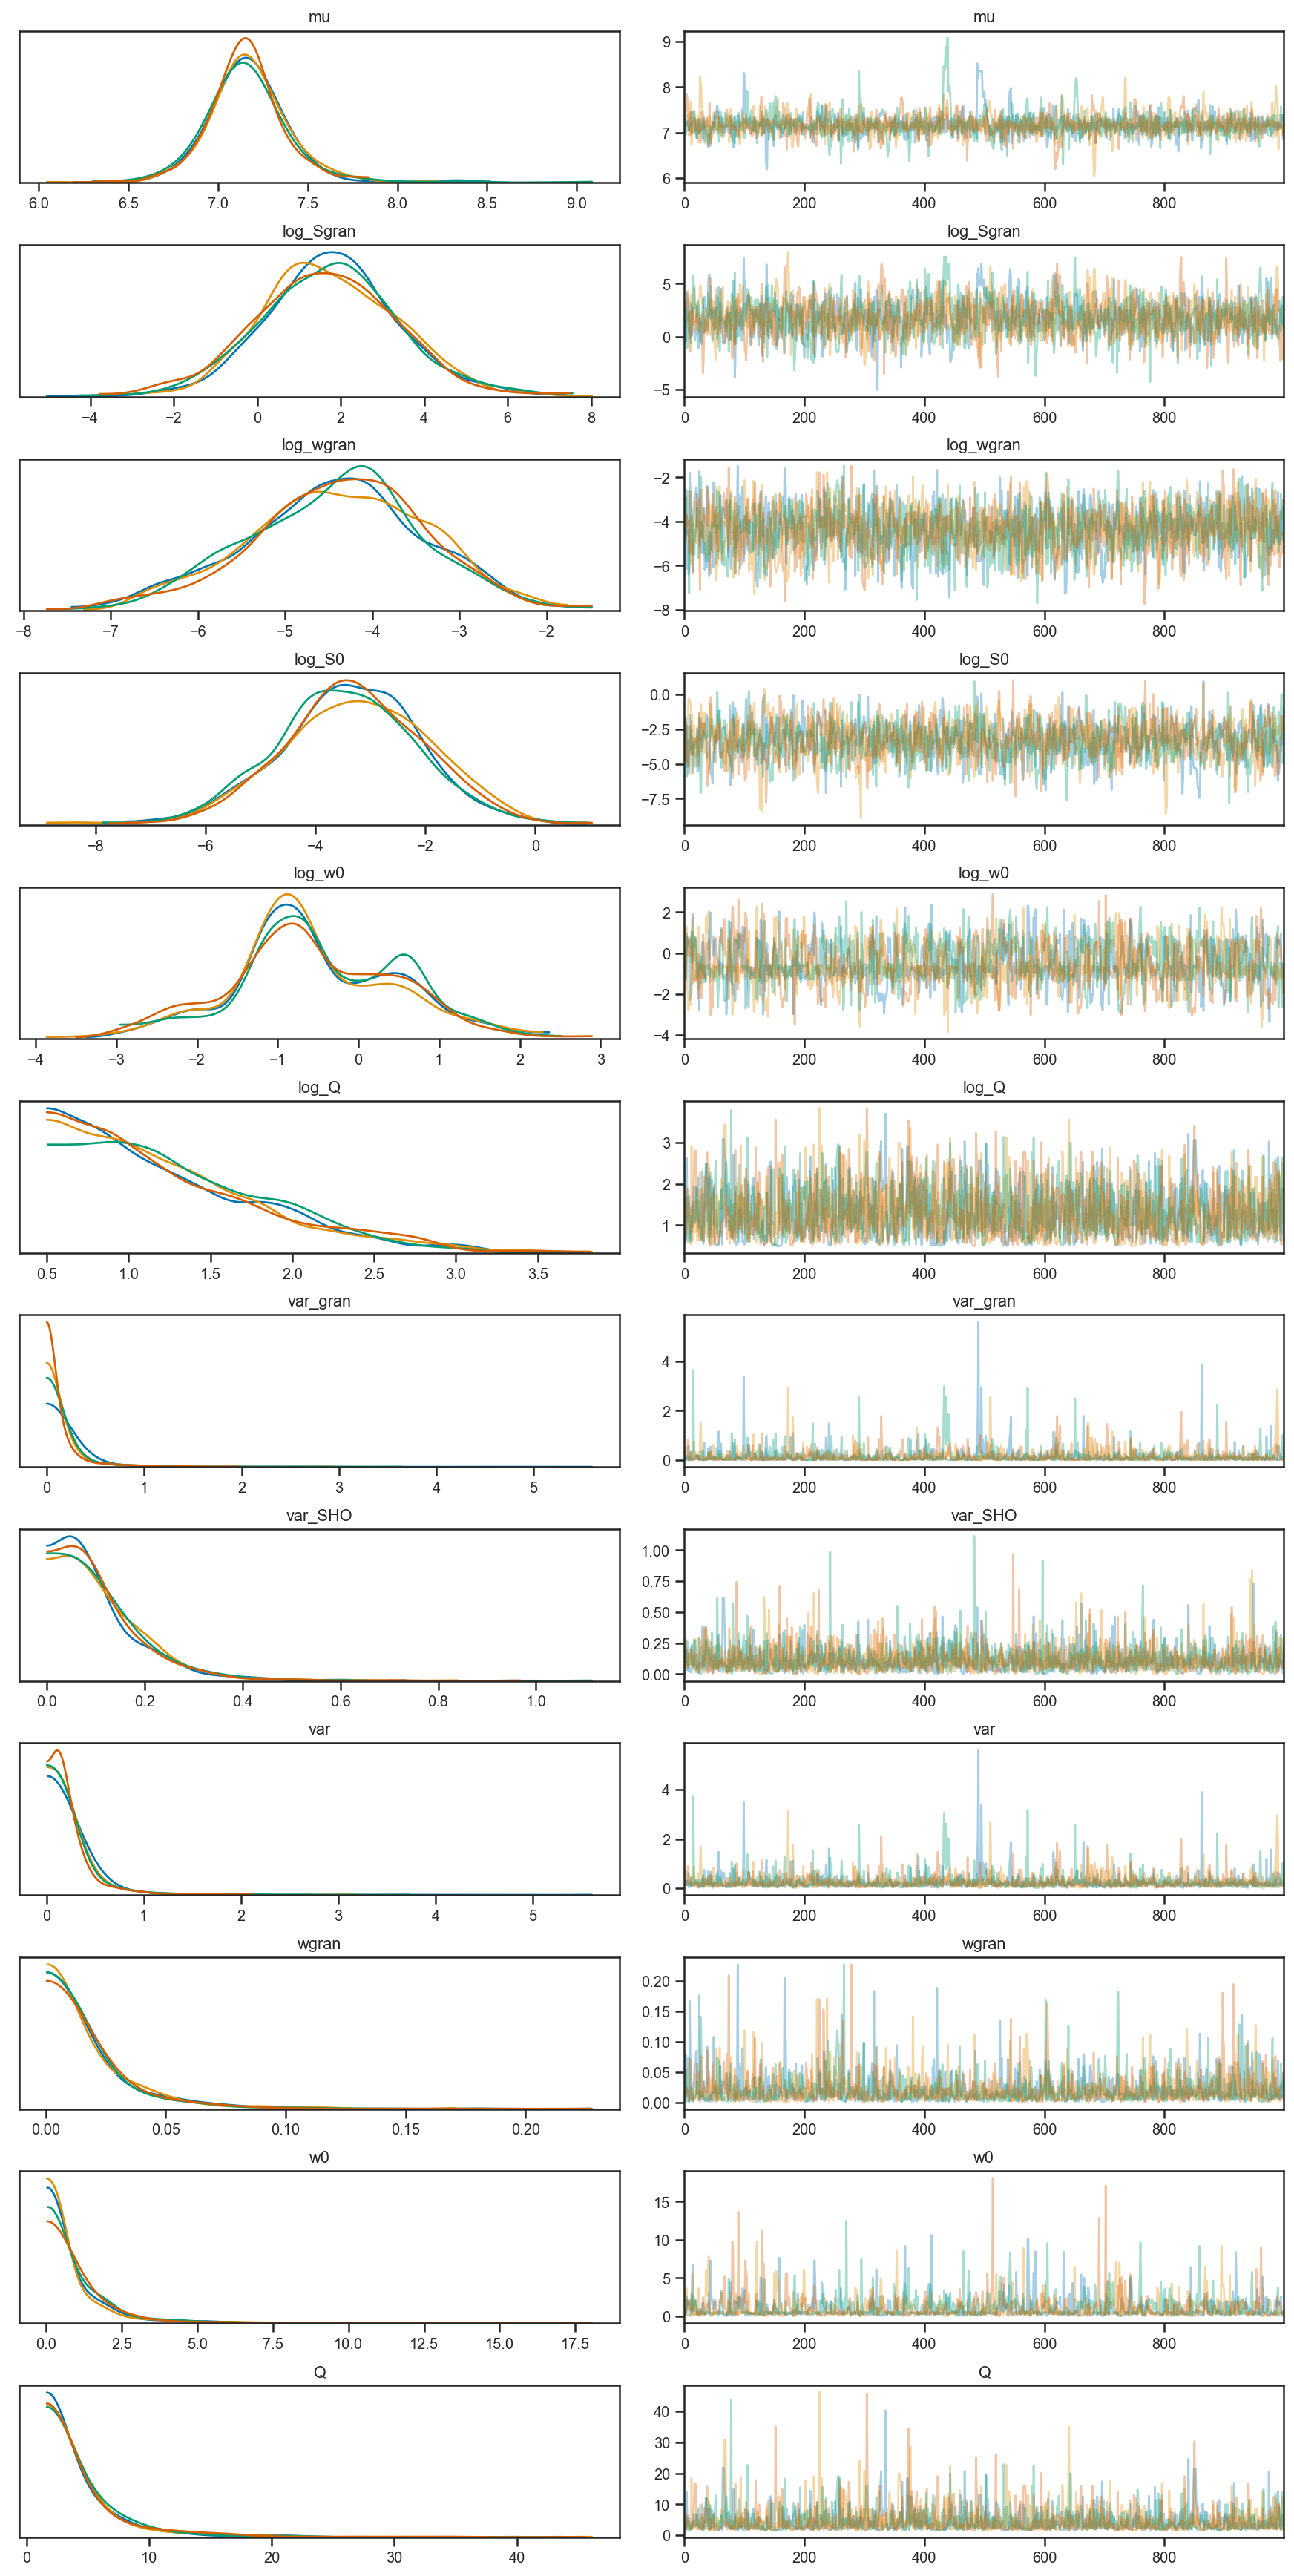

In [22]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pm.plot_trace(trace)

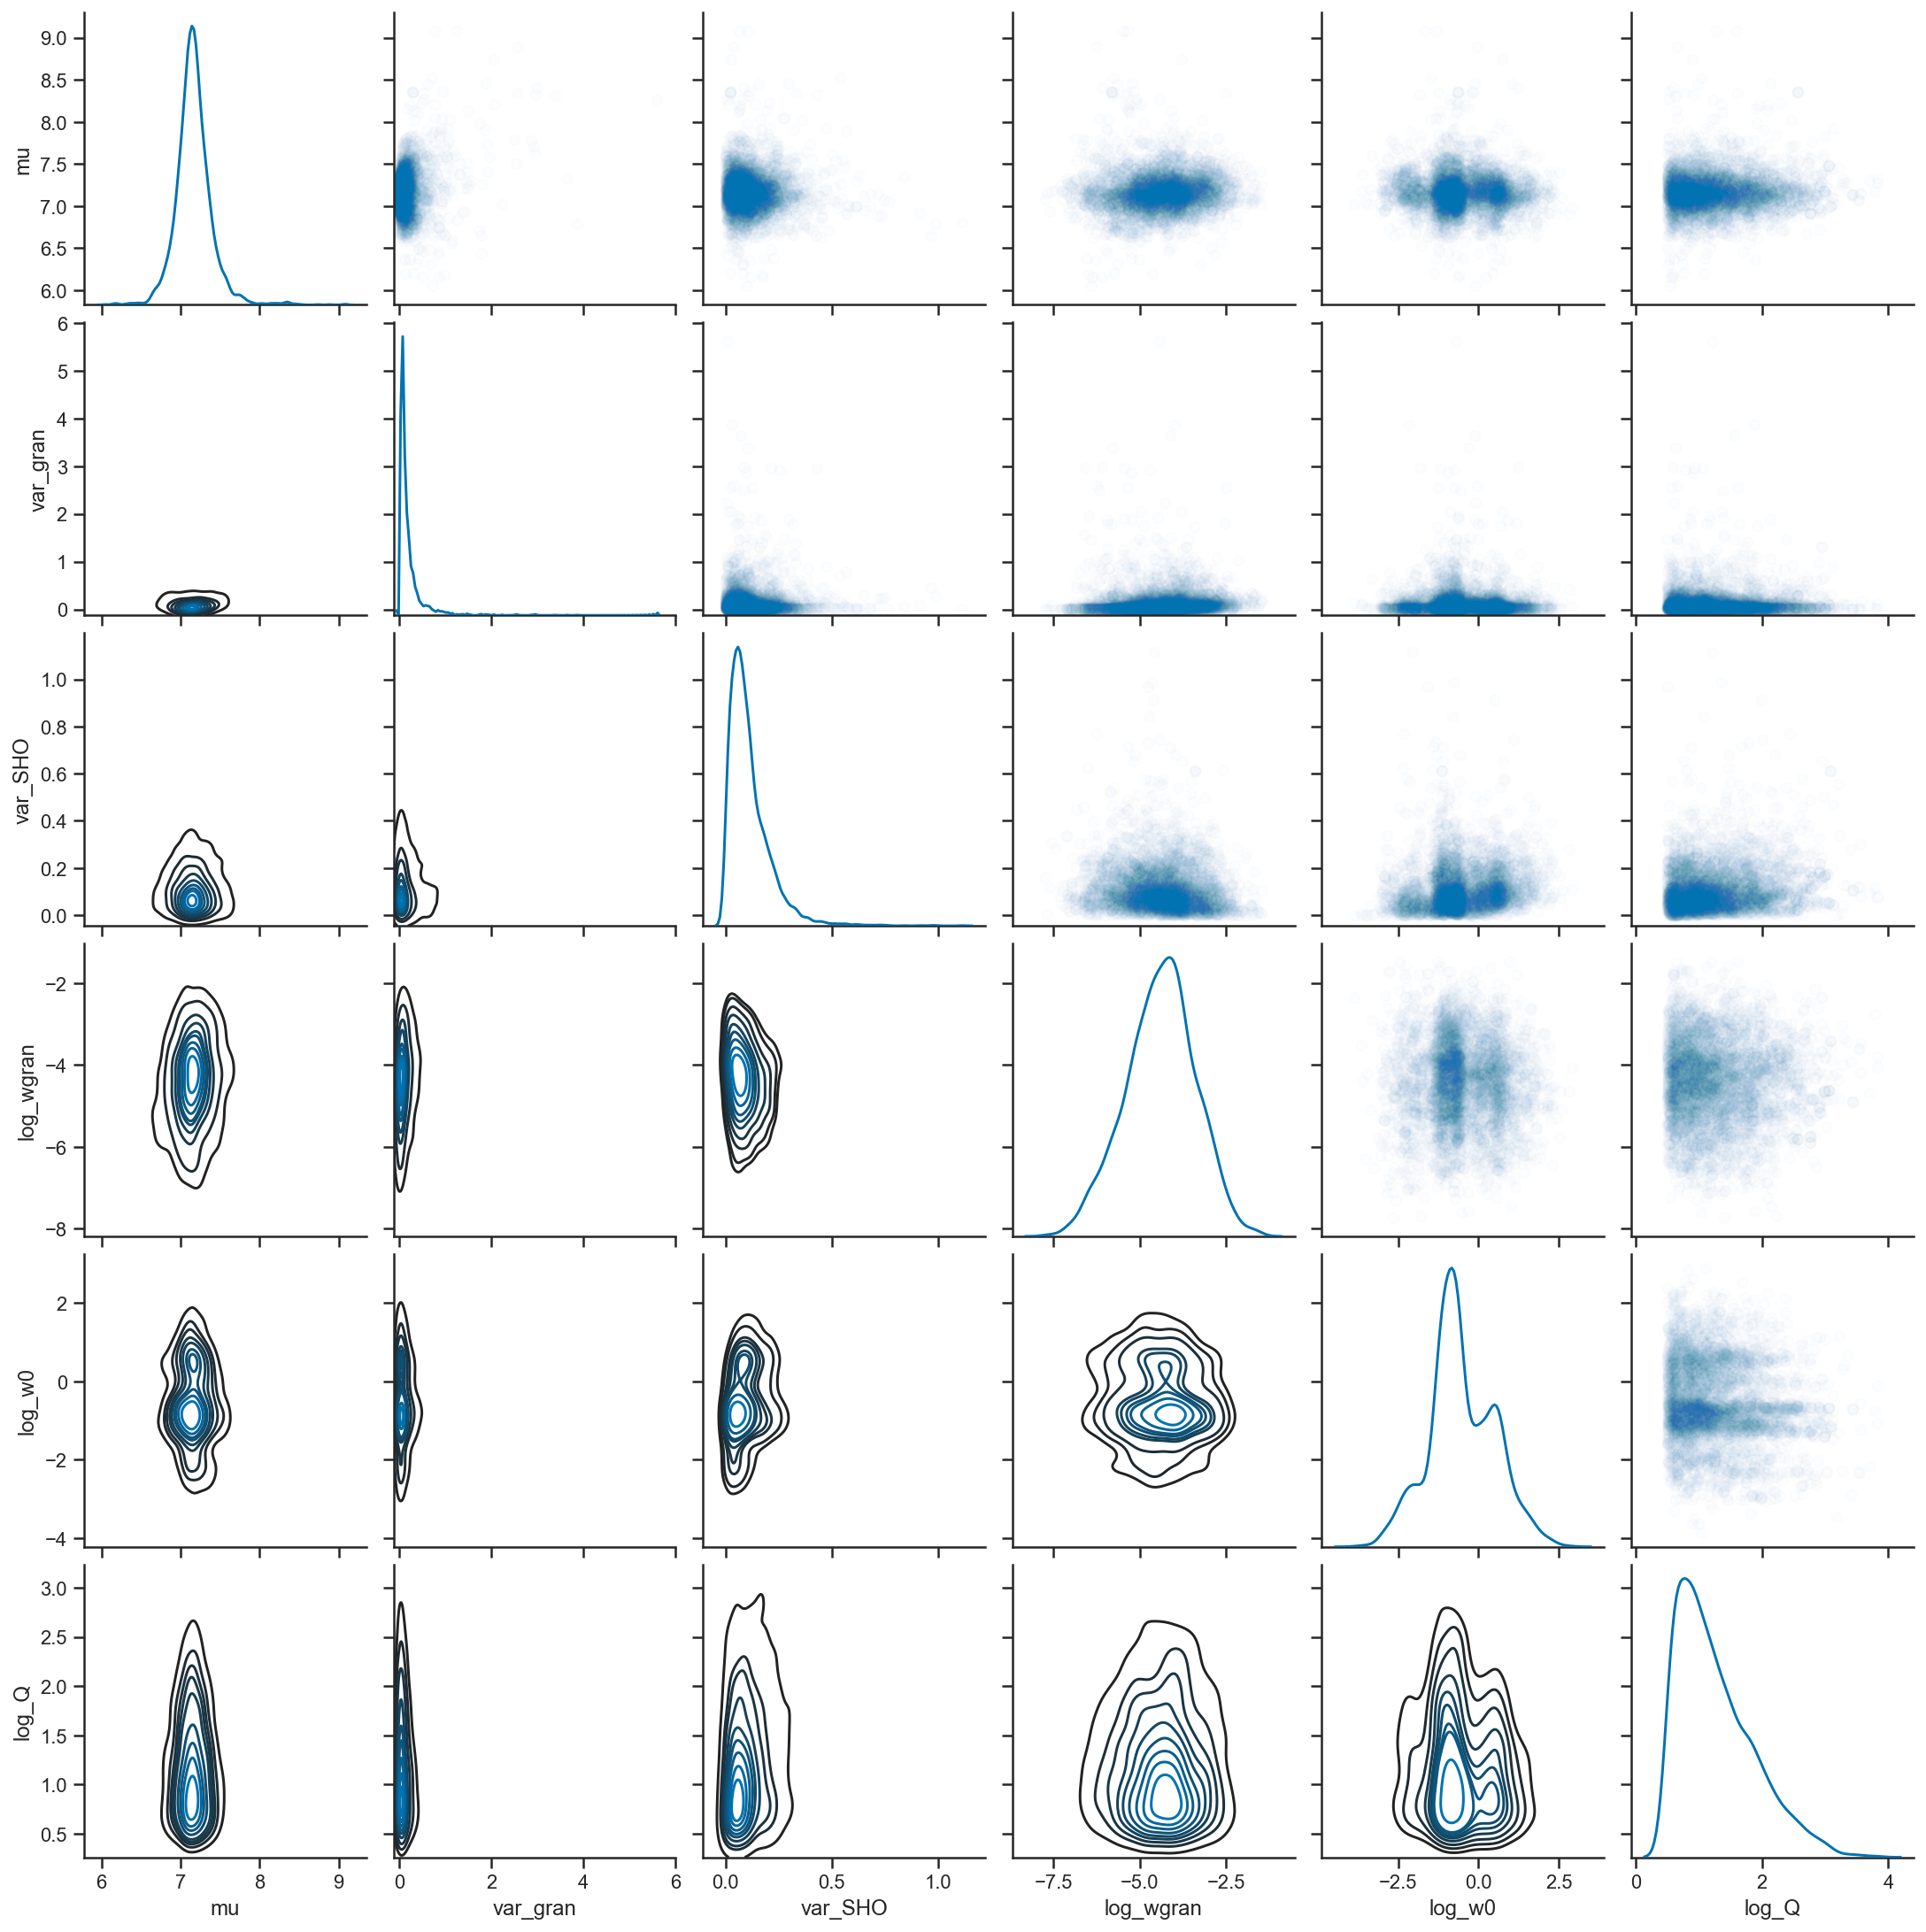

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df = pm.trace_to_dataframe(trace)
    g = sns.PairGrid(df, diag_sharey=False, vars=['mu', 'var_gran', 'var_SHO', 'log_wgran', 'log_w0', 'log_Q'])

    g.map_diag(sns.kdeplot)
    g.map_upper(scatter, alpha=0.01)
    g.map_lower(kdeplot_2d_clevels)

In [27]:
Nt = 1024
tpred = linspace(d['JD'].min(), d['JD'].max(), Nt)

In [28]:
Np = 50
pred_mu = empty((Np, Nt))
pred_var = empty((Np, Nt))
with model:
    pred = gp.predict(tpred, return_var=True)
    for i, sample in enumerate(xo.get_samples_from_trace(trace, size=Np)):
        pred_mu[i], pred_var[i] = xo.eval_in_model(pred, sample)

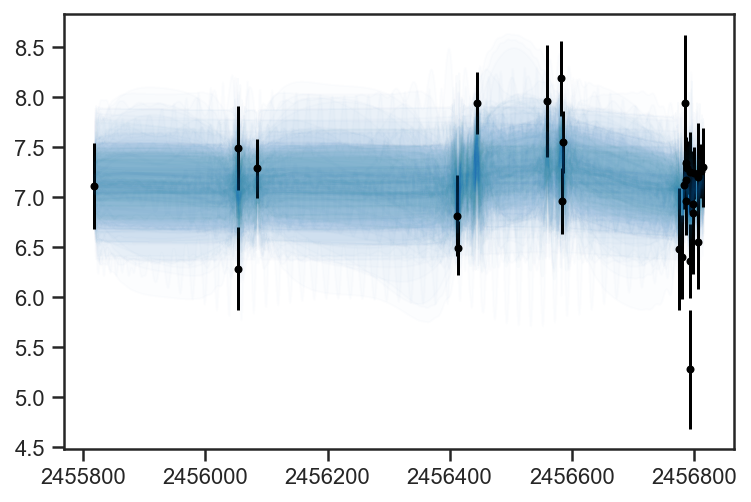

In [29]:
errorbar(d['JD'], d['VHELIO'], d['VRELERR'], fmt='.', color='k')
for i in range(Np):
    plot(tpred, pred_mu[i], color=sns.color_palette()[0], alpha=0.02)
    fill_between(tpred, pred_mu[i]+sqrt(pred_var[i]), pred_mu[i]-sqrt(pred_var[i]), color=sns.color_palette()[0], alpha=0.01)

(2456770, 2456820, 4.488225082200384, 8.830954141940742)

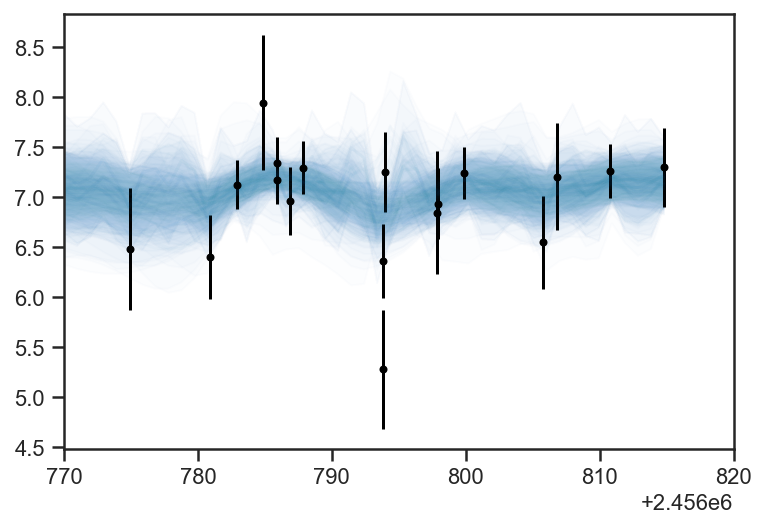

In [33]:
errorbar(d['JD'], d['VHELIO'], d['VRELERR'], fmt='.', color='k')
for i in range(Np):
    plot(tpred, pred_mu[i], color=sns.color_palette()[0], alpha=0.02)
    fill_between(tpred, pred_mu[i]+sqrt(pred_var[i]), pred_mu[i]-sqrt(pred_var[i]), color=sns.color_palette()[0], alpha=0.01)
axis(xmin=2456770, xmax=2456820)

In [35]:
No = 1024
omegas = logspace(log10(d['NUGRAN_EST'].iloc[0]/100.0), log10(d['NUMAX_EST'].iloc[0]*100.0), No)
psd = empty((Np, No))
with model:
    p = kernel.psd(omegas)
    for i, sample in enumerate(xo.get_samples_from_trace(trace, size=Np)):
        psd[i] = xo.eval_in_model(p, sample)

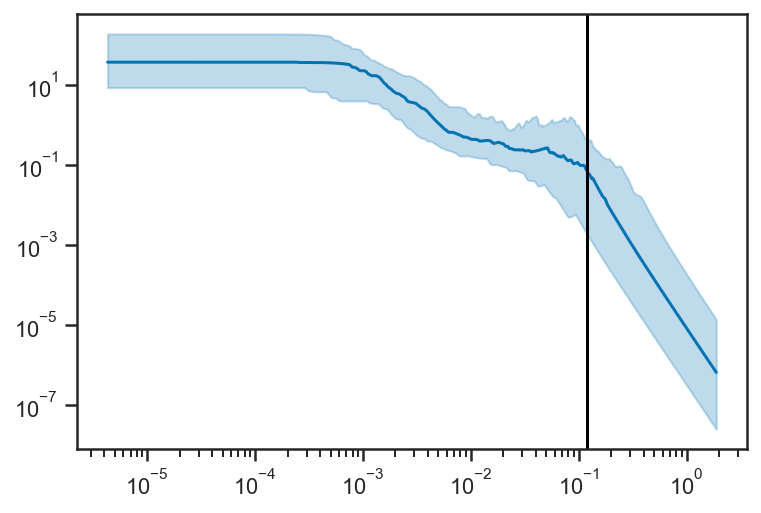

In [36]:
loglog(omegas/(2*pi), 2*pi*median(psd, axis=0))
fill_between(omegas/(2*pi), 2*pi*percentile(psd, 84, axis=0), 2*pi*percentile(psd, 16, axis=0), color=sns.color_palette()[0], alpha=0.25)
axvline(d['NUMAX_EST'].iloc[0], color='k')

numax from fit = 0.94 + 2.3 - 0.47 muHz (compare to estimated 1.4 muHz)


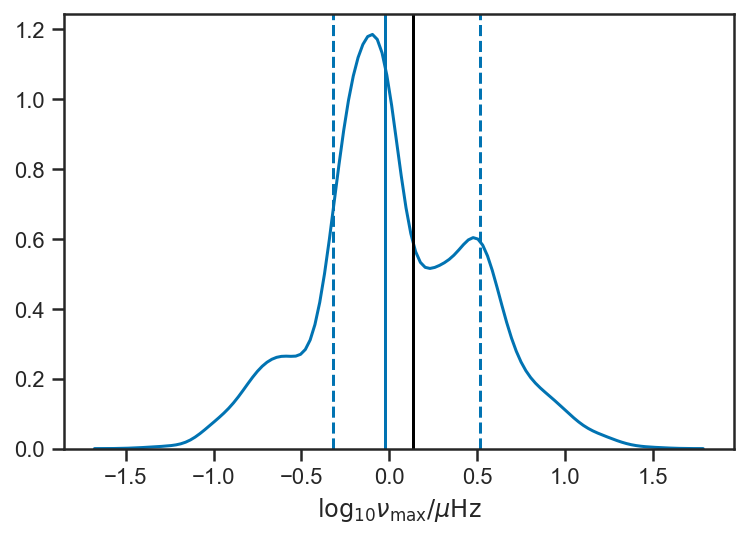

In [39]:
nu0s = exp(trace['log_w0'])/(2*pi)
m = median(nu0s)
h = percentile(nu0s, 84)
l = percentile(nu0s, 16)

per_day_to_muHz = 1e6/(3600.0*24.0)

sns.kdeplot(log10(nu0s*per_day_to_muHz))

xlabel(r'$\log_{10} \nu_\mathrm{max} / \mu\mathrm{Hz}$')

axvline(log10(m*per_day_to_muHz), color=sns.color_palette()[0])
axvline(log10(l*per_day_to_muHz), color=sns.color_palette()[0], ls='--')
axvline(log10(h*per_day_to_muHz), color=sns.color_palette()[0], ls='--')
axvline(log10(d['NUMAX_EST'].iloc[0]*per_day_to_muHz), color='k')

print('numax from fit = {:.2g} + {:.2g} - {:.2g} muHz (compare to estimated {:.2g} muHz)'.format(m*per_day_to_muHz, (h-m)*per_day_to_muHz, (m-l)*per_day_to_muHz, d['NUMAX_EST'].iloc[0]*per_day_to_muHz))